In [20]:
import geopandas as gpd

# KRF로 시작하는 shapefile 찾기
shapefiles = [r"C:\Users\82105\GNN\geumdata\KRF_ver3_CATCHMENT_금강수계.shp",
              r"C:\Users\82105\GNN\geumdata\KRF_ver3_LINE_금강수계.shp",
              r"C:\Users\82105\GNN\geumdata\KRF_ver3_NODE_금강수계.shp",
              r"C:\Users\82105\GNN\geumdata\MASKED2_MMCAT.shp",
              r"C:\Users\82105\GNN\geumdata\merged_geum_river_basin_utf8.shp"]

# shapefile 읽기
masked = gpd.read_file(shapefiles[3])

if masked.crs.to_string() != 'EPSG:4326':
    masked = masked.to_crs(epsg=4326)


catchment_gdf = gpd.clip(gpd.read_file(shapefiles[0]),   masked)
streamline_gdf = gpd.clip(gpd.read_file(shapefiles[1]), masked)
node_gdf = gpd.clip(gpd.read_file(shapefiles[2]), masked)
stations_gdf = gpd.clip(gpd.read_file(shapefiles[4], encoding="utf-8"), masked)


In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

# 노드와 스트림라인 데이터프레임을 가져오기 (예시로 gdfs 중 첫 번째 사용)



# 서브그래프 생성
G = nx.Graph()

# 노드 추가
for idx, row in node_gdf.iterrows():
    x, y = row['geometry'].x, row['geometry'].y
    # row.pop('geometry')
    G.add_node(row['NODE_DID'], pos=(x, y), attr=row.to_dict(), node_type="stream_node")
    

# # 엣지 추가 (INODE_ID -> ONODE_ID)
for idx, row in streamline_gdf.iterrows():
    # row.pop('geometry')
    G.add_edge(row['INODE_DID'], row['ONODE_DID'], attr=row.to_dict())

# 기상관측소 추가
# G.add_node(1, pos=(126.5, 36.5), node_type="weather_station", attr={})
# for node in G.nodes():
#     G.add_edge(1, node)


for idx, station in stations_gdf.iterrows():
    station_point = station.geometry
    # 가장 가까운 노드 찾기
    nearest_geom = nearest_points(station_point, node_gdf.unary_union)[1]
    nearest_node = node_gdf[node_gdf.geometry == nearest_geom]['NODE_DID'].values[0]
    G.nodes[nearest_node]["attr"]["gauge_code"] = int(station["Code"])
    # print(nearest_node, station["Code"])
    # station_node_id = station["Code"]

    # x, y = station_point.x, station_point.y
    # break
    # station.pop('geometry')
    # G.add_node(station_node_id, pos=(x, y), node_type="gauge", attr=station.to_dict())
    # G.add_edge(nearest_node, station_node_id)

for idx, catchment in catchment_gdf.iterrows():
    # catchment의 폴리곤 내에 있는 node_type = "stream_node"인 노드들을 찾아서 해당 catchment의 라벨을 부여
    catchment_polygon = catchment.geometry
    for node_id in G.nodes():
        node = G.nodes[node_id]
        if "node_type" in node and node["node_type"] == "stream_node":
            node_point = node["attr"]["geometry"]
            if catchment_polygon.contains(node_point):
                node["attr"]["catchment_label"] = catchment["SB_ID"]
                node["attr"]["catchment_area"] = catchment["AREA"]

G.remove_node('3014010101')

# guage code가 없는 노드 제거
for node_id in list(G.nodes()):
    node = G.nodes[node_id]
    if "gauge_code" not in node["attr"]:
        G.remove_node(node_id)







In [23]:
G.nodes(data=True)

NodeDataView({'3001011500': {'pos': (127.52960840100002, 35.72019274100006), 'attr': {'OBJECTID': 2760, 'NODE_ID': '30010115', 'NODE_DID': '3001011500', 'NODE_X': 127.529608, 'NODE_Y': 35.720193, 'WGM_ID': None, 'WGM_NM': None, 'WTM_ID': None, 'WTM_NM': None, 'WAM_ID': None, 'WAM_NM': None, 'DAM_NM': None, 'BO_NM': None, 'LU_RCH_ID': '30010113', 'LU_RCH_DID': '3001011300', 'RU_RCH_ID': '30010114', 'RU_RCH_DID': '3001011400', 'LD_RCH_ID': '30010115', 'LD_RCH_DID': '3001011500', 'RD_RCH_ID': None, 'RD_RCH_DID': None, 'NODE_SN': '15', 'NODE_DIV': '00', 'RCH_NUM': 3.0, 'S_FLAG': 0.0, 'E_FLAG': 0.0, 'C_FLAG': 1.0, 'DAM_FLAG': 0.0, 'BO_FLAG': 0.0, 'WGM_FLAG': 0.0, 'WTM_FLAG': 0.0, 'WAM_FLAG': 0.0, 'SB_FLAG': 0.0, 'R_FLAG': 0.0, 'FLAG_ID': '1000000', 'geometry': <POINT (128 35.7)>, 'gauge_code': 3001605}, 'node_type': 'stream_node'}, '3001020900': {'pos': (127.5789257890001, 35.72945275600006), 'attr': {'OBJECTID': 2784, 'NODE_ID': '30010209', 'NODE_DID': '3001020900', 'NODE_X': 127.578926, '

In [169]:
import pandas as pd
wl_df = pd.read_csv(r"C:\Users\82105\GNN\geumdata\wl.csv")
wl_df.index = pd.to_datetime(wl_df["ymd"])
# fill wl values to 0 if there's negative value
wl_df["wl"] = wl_df["wl"].apply(lambda x: 0 if x < 0 else x)
wl_df["Station_Co"] = wl_df["Station_Co"].astype(int)
weather = pd.read_csv(r"C:\Users\82105\GNN\geumdata\weather.csv", encoding="cp949")
weather.index = pd.to_datetime(weather["일시"])
weather = weather[["평균기온(°C)","최고기온(°C)", "최저기온(°C)", "일강수량(mm)", "평균 풍속(m/s)", "평균 상대습도(%)"]]
weather.rename(columns={"평균기온(°C)":"temp", "최고기온(°C)":"tmax",\
                         "최저기온(°C)":"tmin", "일강수량(mm)":"rf", "평균 풍속(m/s)":"wind", "평균 상대습도(%)":"humidity"}, inplace=True)
weather["rf"] = weather["rf"].fillna(0)
weather.interpolate(method="polynomial", order=3, inplace=True)

wl_mean, wl_std = wl_df["wl"].mean(), wl_df["wl"].std()

wl_df["wl"] = (wl_df["wl"] - wl_df["wl"].mean()) / wl_df["wl"].std()
weather["temp"] = (weather["temp"] - weather["temp"].mean()) / weather["temp"].std()
weather["tmax"] = (weather["tmax"] - weather["tmax"].mean()) / weather["tmax"].std()
weather["tmin"] = (weather["tmin"] - weather["tmin"].mean()) / weather["tmin"].std()
weather["rf"] = (weather["rf"] - weather["rf"].mean()) / weather["rf"].std()

In [170]:
import numpy as np

def generate_dynamic_graph_at_time_t(G:nx.Graph, time, wl:pd.DataFrame, weather:pd.DataFrame):
    G_t = G.copy()
    for node in G_t.nodes(data=True):
                gauge_code = np.int32(node[1]['attr']['gauge_code'])  # Convert to numpy.int32
                if gauge_code in wl["Station_Co"].values:
                    wl["wl"][wl["Station_Co"] == gauge_code]
                    G_t.nodes[node[0]]['attr']['water_level'] = wl["wl"][wl["Station_Co"] == gauge_code].loc[time]
                    G_t.nodes[node[0]]['attr']['rf'] = weather["rf"][time]
                    G_t.nodes[node[0]]['attr']['tmax'] = weather["tmax"][time]
                    G_t.nodes[node[0]]['attr']['tmin'] = weather["tmin"][time]
    return G_t

In [171]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader, Dataset
import torch_geometric
import networkx as nx
import torch_geometric.transforms as T
# with open('./fordynamic/geum_river_basin_graph.json') as f:
#     graph_data = json.load(f)
# # Create the graph
# G = nx.node_link_graph(graph_data)

# Convert node IDs to integers if they are not already

mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)




time_steps = weather.index
graphs = []
node_features = []

for t in time_steps:
    G_t = generate_dynamic_graph_at_time_t(G, str(t).split(" ")[0], wl_df, weather)
    # Extract node features
    features = []
    for node in G_t.nodes(data=True):
        attr = node[1]['attr']
        features = [attr.get('water_level', -1), attr.get('rf', -1), attr.get('tmax', -1), attr.get('tmin', -1)]
        node_features.append(features)
    
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor([(u, v) for u, v, data in G.edges(data=True)]).t().contiguous()    
    data = Data(x=x, edge_index=edge_index, transform=T.NormalizeFeatures())
    graphs.append(data)
    node_features = []


    


In [206]:
data.x.numpy()
# save the sample data.x.numpy() to a txt file
np.savetxt('data_x.txt', data.x.numpy())
np.savetxt('edge_index.txt', data.edge_index.numpy())

In [202]:
torch.save(graphs, "geum_river_basin_graph_87.pt")

In [201]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GCN_LSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_LSTM, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.lstm = torch.nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        seq_len, num_nodes, num_features = x.size()
        x = x.view(seq_len, -1)
        x = self.conv1(x, edge_index)
        
        # # LSTM expects input as (batch_size, seq_len, input_size)
        
        # # LSTM
        x, _ = self.lstm(x)
        
        # Fully connected layer
        x = self.fc(x[:, -1, :])
        
        return x
    
    
model = GCN_LSTM(in_channels=4, hidden_channels=16, out_channels=1)
graphs[0].x.shape




torch.Size([87, 4])

In [277]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# Parameters
in_channels = 4
out_channels = 64

# Create model
encoder = GCNEncoder(in_channels, out_channels)
model = GAE(encoder)


# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    total_loss = 0
    for data in graphs:
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graphs)

# Training loop
epochs = 10
for epoch in range(epochs):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 0, Loss: 7.0866


In [278]:
model.eval()
with torch.no_grad():
    results = []
    for data in graphs:
        z = model.encode(data.x, data.edge_index)
        # Reconstructed edge indices
        edge_index_pred = model.decode(z, data.edge_index)
        results.append(z)
    

In [284]:
embeddings = torch.stack(results)

import torch.nn as nn

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

        # # LSTM expects input as (batch_size, seq_len, input_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = out.unsqueeze(-1)
        return out
    
model = LSTMModel()
# predict for node 0
embeddings.shape


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, target_node, wl_df,window_size=7):
        """
        Args:
            embeddings (torch.Tensor): The embeddings tensor of shape (730, 87, 64).
            target_node (int): The index of the target node to predict.
            window_size (int): The number of days to use for prediction.
        """
        self.embeddings = embeddings
        self.target_node = target_node
        self.window_size = window_size
        
        self.wl = wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].values
        self.wl_mean, self.wl_std = self.wl.mean(), self.wl.std()
        self.wl = (self.wl - self.wl_mean) / self.wl_std


    def __len__(self):
        return len(self.embeddings) - self.window_size

    def __getitem__(self, idx):
        """
        Returns a tuple (input_sequence, target_value) where:
        - input_sequence is the embeddings for the target node over the past `window_size` days
        - target_value is the target node's embedding for the next day
        """
        input_sequence = self.embeddings[idx:idx + self.window_size, self.target_node, :]
        target_value = torch.tensor(self.wl[idx + self.window_size], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        return input_sequence, target_value

# Example usage
target_node = 1 # Example target node index
dataset = CustomDataset(embeddings, target_node, wl_df=wl_df)

# Check the first item
input_sequence, target_value = dataset[0]
print(f"Input sequence shape: {input_sequence.shape}")  # Should be (7, 64)
print(f"Target value shape: {target_value.shape}")      # Should be (64,)



Input sequence shape: torch.Size([7, 64])
Target value shape: torch.Size([1, 1])


In [320]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

        # # LSTM expects input as (batch_size, seq_len, input_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = out.unsqueeze(-1)
        return out
    


class CustomDatasetForLSTM(torch.utils.data.Dataset):
    def __init__(self, loader_type, target_node, wl_df,window_size=7):

        self.target_node = target_node
        self.window_size = window_size
        self.loader_type = loader_type
        
        self.wl = wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].values
        self.wl_mean, self.wl_std = self.wl.mean(), self.wl.std()
        self.wl = (self.wl - self.wl_mean) / self.wl_std
        if loader_type == "train":
            self.wl = self.wl[:365]
        else:
            self.wl = self.wl[365:]

    def __len__(self):
        return len(self.wl) - self.window_size

    def __getitem__(self, idx):
        """
        Returns a tuple (input_sequence, target_value) where:
        - input_sequence is the embeddings for the target node over the past `window_size` days
        - target_value is the target node's embedding for the next day
        """
        input_sequence = torch.tensor(self.wl[idx:idx + self.window_size], dtype=torch.float32)
        target_value = torch.tensor(self.wl[idx + self.window_size], dtype=torch.float32).unsqueeze(-1)
        return input_sequence, target_value

In [321]:
loader = torch.utils.data.DataLoader(CustomDatasetForLSTM("train", target_node, wl_df), batch_size=32, shuffle=True)
inputs, targets = next(iter(loader))
inputs.shape, targets.shape

(torch.Size([32, 7]), torch.Size([32, 1]))

In [327]:
from torch.utils.data import DataLoader
def train_lstm(model,target_node, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    train_loader = DataLoader(CustomDatasetForLSTM("train", target_node, wl_df), batch_size=64, shuffle=True)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, (input_sequence, target_value) in enumerate(train_loader):
            input_sequence, target_value = input_sequence.unsqueeze(-1), target_value.unsqueeze(-1)
            # print(input_sequence.shape, target_value.shape)
            optimizer.zero_grad()
            output = model(input_sequence)
            loss = criterion(output, target_value)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
    return model

model = LSTMModel(input_size=1)
for node in G.nodes():
    train_lstm(model, node, epochs=50)



torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([38, 7, 1]) torch.Size([38, 1, 1])
Epoch 0, Train Loss: 0.4283
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([38, 7, 1]) torch.Size([38, 1, 1])
Epoch 1, Train Loss: 0.3234
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([38, 7, 1]) torch.Size([38, 1, 1])
Epoch 2, Train Loss: 0.3193
torch.Size([64, 7, 1]) torch.Size([64, 1, 1])
torch.Size([64, 7, 1]) torch.Size([64, 1, 

In [285]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=64)
test_loader = DataLoader(dataset, batch_size=1)

In [286]:
# train the lstm model
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
def train(model, train_loader):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        total_loss = 0
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)
# Train the model
for epoch in range(100):
    for target_node in G.nodes():
        dataset = CustomDataset(embeddings, target_node, wl_df=wl_df)
        train_loader = DataLoader(dataset, batch_size=64)
        loss = train(model, train_loader)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')





Epoch 0, Loss: 0.1372
Epoch 0, Loss: 0.0431
Epoch 0, Loss: 0.0768
Epoch 0, Loss: 0.1044
Epoch 0, Loss: 0.0523
Epoch 0, Loss: 0.0910
Epoch 0, Loss: 0.0275
Epoch 0, Loss: 0.0022
Epoch 0, Loss: 0.0196
Epoch 0, Loss: 0.1229
Epoch 0, Loss: 0.1316
Epoch 0, Loss: 0.0829
Epoch 0, Loss: 0.0569
Epoch 0, Loss: 0.0119
Epoch 0, Loss: 0.0269
Epoch 0, Loss: 0.0549
Epoch 0, Loss: 0.0174
Epoch 0, Loss: 0.0789
Epoch 0, Loss: 0.0074
Epoch 0, Loss: 0.0187
Epoch 0, Loss: 0.1062
Epoch 0, Loss: 0.0222
Epoch 0, Loss: 0.0326
Epoch 0, Loss: 0.0512
Epoch 0, Loss: 0.1012
Epoch 0, Loss: 0.0485
Epoch 0, Loss: 0.0534
Epoch 0, Loss: 0.1338
Epoch 0, Loss: 0.0863
Epoch 0, Loss: 0.0644
Epoch 0, Loss: 0.0907
Epoch 0, Loss: 0.0201
Epoch 0, Loss: 0.0157
Epoch 0, Loss: 0.0295
Epoch 0, Loss: 0.0087
Epoch 0, Loss: 0.0680
Epoch 0, Loss: 0.2479
Epoch 0, Loss: 0.1099
Epoch 0, Loss: 0.0061
Epoch 0, Loss: 0.0344
Epoch 0, Loss: 0.1594
Epoch 0, Loss: 0.0126
Epoch 0, Loss: 0.0161
Epoch 0, Loss: 0.0490
Epoch 0, Loss: 0.0361
Epoch 0, L

KeyboardInterrupt: 

In [291]:
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader

def plot_and_save_prediction(model, target_node, embeddings, wl_df):
    model.eval()
    observations = []
    predictions = []

    test_loader = DataLoader(CustomDataset(embeddings, target_node, wl_df=wl_df), batch_size=1)
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            observations.append(targets.reshape(-1).numpy())
            predictions.append(outputs.reshape(-1).numpy())

    observations = np.concatenate(observations)
    predictions = np.concatenate(predictions)

    # find wl_std, wl_mean for given target node
    wl_mean, wl_std = wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].mean(), wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].std()
    observations_value = observations * wl_std + wl_mean
    predictions_value = predictions * wl_std + wl_mean

    plt.plot(observations_value, label='Observations')
    plt.plot(predictions_value, label='Predictions')
    plt.legend()
    plt.title(f'Water Level Prediction for Node {target_node}')
    plt.savefig(f'prediction_{target_node}.png')
    plt.close()

    # save results to a csv file
    results = pd.DataFrame({"Observations": observations_value, "Predictions": predictions_value, "Station_Co": G.nodes[target_node]["attr"]["gauge_code"], "Station_Name": wl_df["측정소명"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].values[0]})
    results.to_csv("results_{}.csv".format(target_node), index=False)

# Use the function for each target node
for target_node in G.nodes():
    plot_and_save_prediction(model, target_node, embeddings, wl_df)

In [298]:
import glob
paths = glob.glob("./result/results_*.csv")
dfs = [pd.read_csv(path) for path in paths]

# make evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
def kge(y_obs, y_sim):
    r = np.corrcoef(y_obs, y_sim)[0,1]
    alpha = np.std(y_sim) / np.std(y_obs)
    beta = np.sum(y_sim) / np.sum(y_obs)
    kge = 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)
    return kge

def nse(y_obs, y_sim):
    mean_obs = np.mean(y_obs)
    numerator = np.sum((y_obs - y_sim) ** 2)
    denominator = np.sum((y_obs - mean_obs) ** 2)
    nse = 1 - numerator / denominator
    return nse

def evaluate_results(results):
    rmse = np.sqrt(mean_squared_error(results["Observations"], results["Predictions"]))
    r2 = r2_score(results["Observations"], results["Predictions"])
    kge_score = kge(results["Observations"], results["Predictions"])
    nse_score = nse(results["Observations"], results["Predictions"])
    station_name = results["Station_Name"].values[0]
    station_code = results["Station_Co"].values[0]
    return rmse,  kge_score, nse_score, station_name, station_code

# Evaluate each result
evaluation_results = [evaluate_results(df) for df in dfs]
evaluation_df = pd.DataFrame(evaluation_results, columns=["MSE", "KGE", "NSE", "Station_Name", "Station_Code"])
evaluation_df.to_csv("evaluation_results.csv", index=False)

In [330]:
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader

def plot_and_save_prediction(model, target_node, wl_df):
    model.eval()
    observations = []
    predictions = []

    test_loader = DataLoader(CustomDatasetForLSTM("test",target_node, wl_df=wl_df), batch_size=1)
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.unsqueeze(-1)
            
            outputs = model(inputs)
            observations.append(targets.reshape(-1).numpy())
            predictions.append(outputs.reshape(-1).numpy())

    observations = np.concatenate(observations)
    predictions = np.concatenate(predictions)

    # find wl_std, wl_mean for given target node
    wl_mean, wl_std = wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].mean(), wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].std()
    observations_value = observations * wl_std + wl_mean
    predictions_value = predictions * wl_std + wl_mean

    plt.plot(observations_value, label='Observations')
    plt.plot(predictions_value, label='Predictions')
    plt.legend()
    plt.title(f'Water Level Prediction for Node {target_node}')
    plt.savefig(f'lstm_prediction_{target_node}.png')
    plt.close()

    # save results to a csv file
    results = pd.DataFrame({"Observations": observations_value, "Predictions": predictions_value, "Station_Co": G.nodes[target_node]["attr"]["gauge_code"], "Station_Name": wl_df["측정소명"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].values[0]})
    results.to_csv("lstm_results_{}.csv".format(target_node), index=False)

# Use the function for each target node
for target_node in G.nodes():
    plot_and_save_prediction(model, target_node, wl_df)

In [332]:
import glob
paths = glob.glob("./result/lstm_results_*.csv")
dfs = [pd.read_csv(path) for path in paths]

# make evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
def kge(y_obs, y_sim):
    r = np.corrcoef(y_obs, y_sim)[0,1]
    alpha = np.std(y_sim) / np.std(y_obs)
    beta = np.sum(y_sim) / np.sum(y_obs)
    kge = 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)
    return kge

def nse(y_obs, y_sim):
    mean_obs = np.mean(y_obs)
    numerator = np.sum((y_obs - y_sim) ** 2)
    denominator = np.sum((y_obs - mean_obs) ** 2)
    nse = 1 - numerator / denominator
    return nse

def evaluate_results(results):
    rmse = np.sqrt(mean_squared_error(results["Observations"], results["Predictions"]))
    r2 = r2_score(results["Observations"], results["Predictions"])
    kge_score = kge(results["Observations"], results["Predictions"])
    nse_score = nse(results["Observations"], results["Predictions"])
    station_name = results["Station_Name"].values[0]
    station_code = results["Station_Co"].values[0]
    return rmse,  kge_score, nse_score, station_name, station_code

# Evaluate each result
evaluation_results = [evaluate_results(df) for df in dfs]
evaluation_df = pd.DataFrame(evaluation_results, columns=["MSE", "KGE", "NSE", "Station_Name", "Station_Code"])
evaluation_df.to_csv("lstm_evaluation_results.csv", index=False)

In [351]:
lstm_evaluation_df = pd.read_csv("lstm_evaluation_results.csv")
gcn_evaluation_df = pd.read_csv("evaluation_results.csv")

lstm_best = lstm_evaluation_df.iloc[lstm_evaluation_df["NSE"].argmax()]
gcn_best = gcn_evaluation_df.iloc[gcn_evaluation_df["NSE"].argmax()]
lstm_best, gcn_best

(MSE             164.677447
 KGE               0.854541
 NSE               0.813141
 Station_Name     공주시(공주보상)
 Station_Code       3012633
 Name: 54, dtype: object,
 MSE             33.197194
 KGE              0.675789
 NSE              0.771579
 Station_Name     세종시(금남교)
 Station_Code      3012605
 Name: 61, dtype: object)

<Axes: >

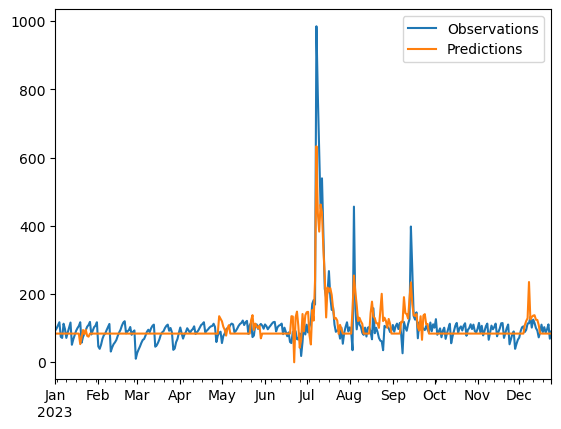

In [350]:
node61 = pd.read_csv("./result/results_34.csv")
node61.index = pd.date_range(start="2022-01-01", periods=len(node61), freq="D")
node61[["Observations", "Predictions"]]["2023-01-01":"2023-12-31"].plot()